# Imports and Functions

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from statsbombpy import sb
import pandas as pd
import numpy as np
from mplsoccer import VerticalPitch, Pitch

In [5]:
def minute_string_to_float(x, hours=False):
    """
    Translate the minutes from string to float (e.g. '45:30' -> 45.5)
    """
    if hours:
        return int(x.split(':')[0])*60 + int(x.split(':')[1]) + float(x.split(':')[2])/60
    else:
        return int(x.split(':')[0]) + int(x.split(':')[1])/60


def find_min_hex(cmap, min_value=0):
    """
    From a colormap, get the hex of the left-extreme color.
    """
    cmap = matplotlib.colormaps[cmap]
    rgba = [int(x*255) for x in cmap(min_value)]
    return '#{:02x}{:02x}{:02x}'.format(*rgba)


def parse_positions(l, game_duration=90):
    """
    from the positions list, get how many minutes the player had played.
    """
    if not l:
        return 0
        
    minutes = 0
    for position in l:
        ini = minute_string_to_float(position['from'])
        if position['to'] is not None:
            fi = minute_string_to_float(position['to'])
        else:
            fi = game_duration

        minutes += (fi-ini)
    return minutes

# Prepare the Data

In [7]:
# Get all competition and season matches
competition_row = sb.competitions()[
    (sb.competitions()['competition_name'] == 'La Liga') 
    & (sb.competitions()['season_name'] == '2015/2016')
]
competition_id = pd.unique(
    competition_row['competition_id']
)[0]
season_id = pd.unique(
    competition_row['season_id']
)[0]

matches = sb.matches(competition_id=competition_id, season_id=season_id)
print('All teams:', pd.unique(matches['home_team']))

All teams: ['Levante UD' 'Las Palmas' 'RC Deportivo La Coruña' 'Málaga' 'Espanyol'
 'Sporting Gijón' 'Rayo Vallecano' 'Real Betis' 'Athletic Club'
 'Atlético Madrid' 'Valencia' 'Eibar' 'Getafe' 'Villarreal' 'Sevilla'
 'Granada' 'Real Sociedad' 'Celta Vigo' 'Real Madrid' 'Barcelona']


In [9]:
# Select team here
team = 'Barcelona'

team_matches = matches[(matches['home_team'] == team) | (matches['away_team'] == team)]

all_events = None
minutes = {} # match_id: minutes
for match_id in pd.unique(team_matches['match_id']):
    match_events = sb.events(match_id=match_id)
    match_events['minutes'] = match_events[
        (match_events['type'] == 'Half End') 
        & (match_events['team'] == team)
    ]['timestamp'].apply(lambda x: minute_string_to_float(x, True)).sum()
    
    if all_events is None:
        all_events = match_events.copy()
    else:
        all_events = pd.concat([all_events, match_events], join="inner")
        
shots_against_team = all_events.loc[
    (all_events['type'] == 'Shot') 
    & (all_events['team'] != team) 
    & (all_events['shot_type'] == 'Open Play')
].set_index('id')

shots_against_team['x'] = shots_against_team['location'].apply(lambda x: x[0])
shots_against_team['y'] = shots_against_team['location'].apply(lambda x: x[1])
shots_against_team['time'] =  shots_against_team.apply(lambda x: f"{str(x['minute']).zfill(2)}:{str(x['second']).zfill(2)}", axis=1)

columns = ['match_id', 'x', 'y', 'minute', 'second', 'player', 'position', 'shot_outcome', 'shot_type', 'minutes', 'time']
shots_against_team = shots_against_team[columns]

# Team Level Analysis

Barcelona conceded 26 goals


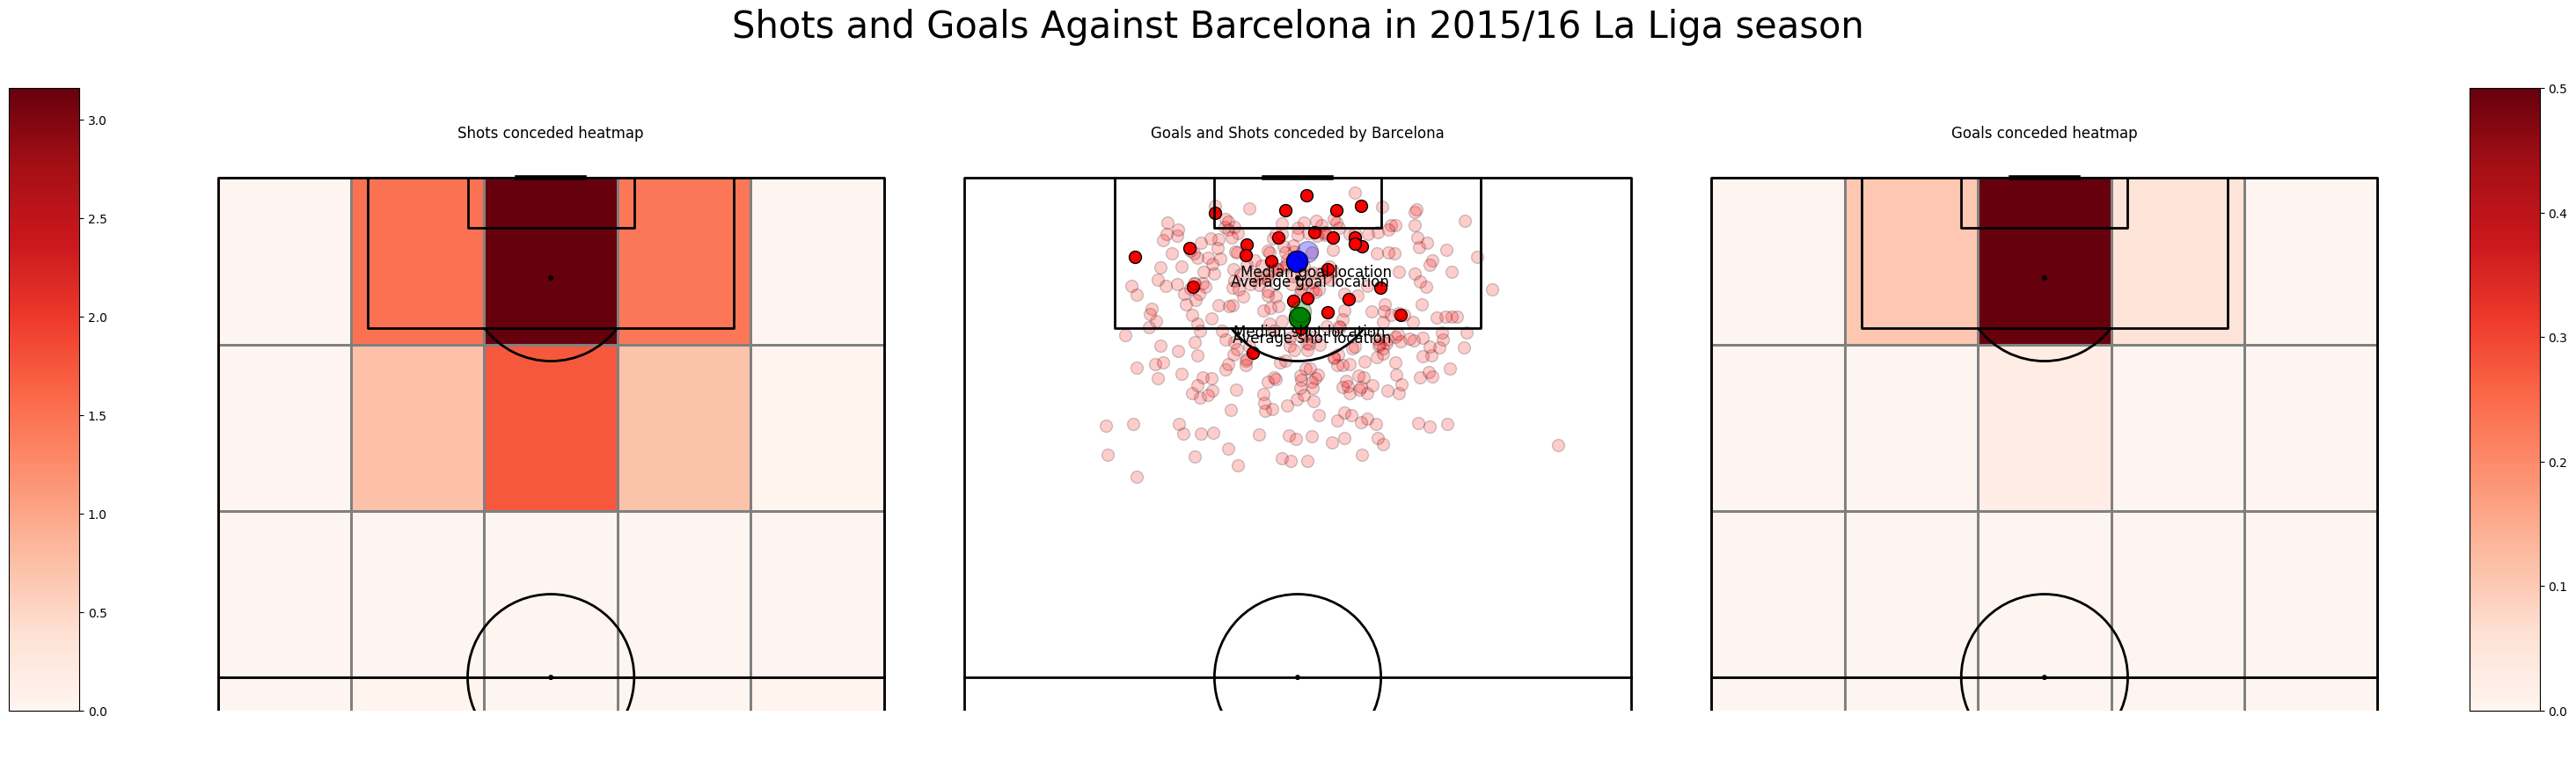

In [10]:
# Plot a 3-ax figure with two heatmaps and one shot/goal positions
pitch = VerticalPitch(line_zorder=2, line_color='black', half = True)
fig, axs = pitch.grid(nrows=1, ncols=3, axis=False, endnote_height=0.05)

# Display shots and goals positions
for row in shots_against_team.itertuples():
    if row.shot_outcome == 'Goal':
        alpha = 1
        #sum_goal_x += row.x
        #sum_goal_y += row.y
    else:
        alpha = 0.2
    pitch.scatter(
        row.x, 
        row.y, 
        alpha = alpha, 
        s = 100, 
        color = "red", 
        ax=axs['pitch'][1],
        edgecolors="black"
    )

# Plot the avg shot location (green)
pitch.scatter(
    shots_against_team.x.mean(), 
    shots_against_team.y.mean(), 
    alpha = 1, 
    s = 300, 
    color = "green", 
    ax=axs['pitch'][1],
    edgecolors="black"
)
pitch.annotate('Average shot location', (shots_against_team.x.mean() -3, shots_against_team.y.mean() - 8), ax=axs['pitch'][1], fontsize = 12)

# Plot the avg shot location (green)
pitch.scatter(
    shots_against_team.x.median(), 
    shots_against_team.y.median(), 
    alpha = 0.3, 
    s = 300, 
    color = "green", 
    ax=axs['pitch'][1],
    edgecolors="black"
)
pitch.annotate('Median shot location', (shots_against_team.x.median() -3, shots_against_team.y.median() - 8), ax=axs['pitch'][1], fontsize = 12)
    
# Plot the avg goal location (blue)
avg_x = shots_against_team.loc[shots_against_team['shot_outcome'] == 'Goal', 'x'].mean() 
avg_y = shots_against_team.loc[shots_against_team['shot_outcome'] == 'Goal', 'y'].mean()
pitch.scatter(
    avg_x, 
    avg_y, 
    alpha = 1, 
    s = 300, 
    color = "blue", 
    ax=axs['pitch'][1],
    edgecolors="black"
)
pitch.annotate('Average goal location', (avg_x - 3, avg_y - 8), ax=axs['pitch'][1], fontsize = 12)

# Plot the median goal location (blue)
median_x = shots_against_team.loc[shots_against_team['shot_outcome'] == 'Goal', 'x'].median() 
median_y = shots_against_team.loc[shots_against_team['shot_outcome'] == 'Goal', 'y'].median()
pitch.scatter(
    median_x, 
    median_y, 
    alpha = 0.3, 
    s = 300, 
    color = "blue", 
    ax=axs['pitch'][1],
    edgecolors="black"
)
pitch.annotate('Median goal location', (median_x - 3, median_y - 8), ax=axs['pitch'][1], fontsize = 12)
axs['pitch'][1].set_title(f'Goals and Shots conceded by {team}')

# Shot heatmap
shot_bin_statistic = pitch.bin_statistic(
    shots_against_team.x, 
    shots_against_team.y, 
    statistic='count', 
    bins=(6, 5), 
    normalize=False
)
#normalize by number of games
shot_bin_statistic["statistic"] = shot_bin_statistic["statistic"]/len(team_matches)
#make a heatmap
pcm  = pitch.heatmap(shot_bin_statistic, cmap='Reds', edgecolor='grey', ax=axs['pitch'][0])
#legend to our plot
ax_cbar = fig.add_axes((-0.05, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
axs['pitch'][0].set_title('Shots conceded heatmap')

# Goal hetmap
goal_bin_statistic = pitch.bin_statistic(
    shots_against_team.loc[shots_against_team['shot_outcome'] == 'Goal'].x, 
    shots_against_team.loc[shots_against_team['shot_outcome'] == 'Goal'].y, 
    statistic='count', 
    bins=(6, 5), 
    normalize=False
)
#normalize by number of games
goal_bin_statistic["statistic"] = goal_bin_statistic["statistic"]/len(team_matches)
#make a heatmap
pcm  = pitch.heatmap(goal_bin_statistic, cmap='Reds', edgecolor='grey', ax=axs['pitch'][2])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
axs['pitch'][2].set_title('Goals conceded heatmap')

print(f"{team} conceded {len(shots_against_team.loc[shots_against_team['shot_outcome'] == 'Goal'])} goals")
fig.suptitle(f"Shots and Goals Against {team} in 2015/16 La Liga season", fontsize = 30)

plt.show()

/var/folders/h5/x4kfssld5_18qx4_3v8pdx6c0000gn/T/ipykernel_79835/1493268129.py:28: RuntimeWarning: invalid value encountered in divide
  goal_shot_ratio['statistic'] = np.divide(goal_bin_statistic['statistic'], shot_bin_statistic['statistic'])


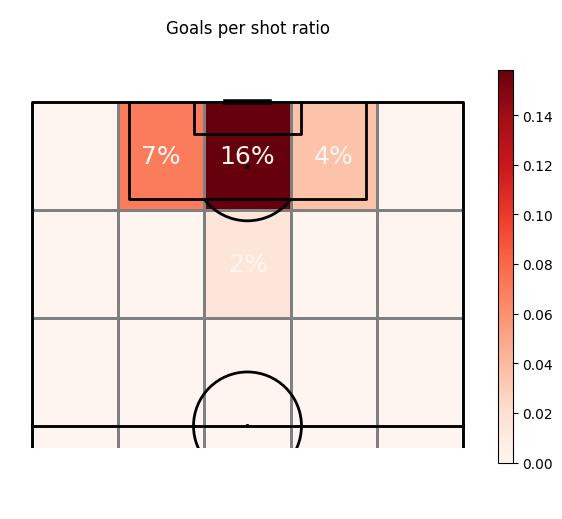

In [5]:
# New KPI: goal_shot_ratio. 
pitch = VerticalPitch(line_zorder=2, line_color='black', half = True, pitch_length=10, pitch_width=5)
fig, axs = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

goal_bin_statistic = pitch.bin_statistic(
    shots_against_team.loc[shots_against_team['shot_outcome'] == 'Goal'].x, 
    shots_against_team.loc[shots_against_team['shot_outcome'] == 'Goal'].y, 
    statistic='count', 
    bins=(6, 5), 
    normalize=False
)
shot_bin_statistic = pitch.bin_statistic(
    shots_against_team.x, 
    shots_against_team.y, 
    statistic='count', 
    bins=(6, 5), 
    normalize=False
)

goal_shot_ratio = goal_bin_statistic.copy()

goal_shot_ratio['statistic'] = np.divide(goal_bin_statistic['statistic'], shot_bin_statistic['statistic'])
goal_shot_ratio['statistic'] = np.nan_to_num(goal_shot_ratio['statistic'])

pcm  = pitch.heatmap(goal_shot_ratio, cmap='Reds', edgecolor='grey', ax=axs['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
labels = pitch.label_heatmap(goal_shot_ratio, color=find_min_hex('Reds'), fontsize=18,
                             ax=axs['pitch'], ha='center', va='center',
                             str_format='{:.0%}', zorder=1)
fig.suptitle('Goals per shot ratio')
fig.set_figwidth(5)
fig.set_figheight(5)
plt.show()

# Player Level Analysis

In [11]:
# Prepare the data
all_lineups = None
for match_id in pd.unique(all_events['match_id']):
    match_lineups = sb.lineups(match_id=match_id)['Barcelona']
    
    match_lineups['match_id'] = match_id
    match_lineups['match_duration'] = all_events[all_events['match_id'] == match_id]['minutes'].unique()[0]
    match_lineups['from'] = match_lineups['positions'].apply(lambda x: x[0]['from'] if x else np.nan)
    match_lineups['to'] = match_lineups.apply(lambda x: x['positions'][-1]['to'] if x['positions'] and x['positions'][-1]['to'] is not None else ('90:00' if x['positions'] else np.nan), axis=1)
    match_lineups['minutes_played'] = match_lineups.apply(lambda x: parse_positions(x['positions'], x['match_duration']), axis=1)
    
    if all_lineups is None:
        all_lineups = match_lineups.copy()
    else:
        all_lineups = pd.concat([all_lineups, match_lineups], join="inner")

all_lineups = all_lineups.reset_index(drop=True)
all_lineups.head()

,player_id,player_name,player_nickname,jersey_number,country,cards,positions,match_id,match_duration,from,to,minutes_played
0,3508,Sandro Ramírez Castillo,Sandro Ramírez,19,Spain,[],"[{'position_id': 17, 'position': 'Right Wing',...",3825660,92.02535,78:18,90:00,13.72535
1,4320,Neymar da Silva Santos Junior,Neymar,11,Brazil,"[{'time': '46:06', 'card_type': 'Yellow Card',...","[{'position_id': 21, 'position': 'Left Wing', ...",3825660,92.02535,00:00,90:00,92.02535
2,4324,Daniel Alves da Silva,Dani Alves,6,Brazil,[],"[{'position_id': 2, 'position': 'Right Back', ...",3825660,92.02535,00:00,90:00,92.02535
3,4691,Claudio Andrés Bravo Muñoz,Claudio Bravo,13,Chile,[],"[{'position_id': 1, 'position': 'Goalkeeper', ...",3825660,92.02535,00:00,90:00,92.02535
4,5203,Sergio Busquets i Burgos,Sergio Busquets,5,Spain,[],"[{'position_id': 10, 'position': 'Center Defen...",3825660,92.02535,00:00,90:00,92.02535


In [12]:
# 2. Add the shots_conceded and goals_conceded columns

for match_id in pd.unique(all_lineups['match_id']):
    match_shots = shots_against_team[shots_against_team['match_id'] == match_id]
    for player_tup in all_lineups[all_lineups['match_id'] == match_id].itertuples():

        # For whatever reason, the 'from' column is being mapped to '_10'
        shots_conceded = match_shots[(match_shots['time'] >= player_tup._10) & (match_shots['time'] <= player_tup.to)]
        goals_conceded = len(shots_conceded[shots_conceded['shot_outcome'] == 'Goal'])
        shots_conceded = len(shots_conceded)
        #print(player_tup.Index, player_tup.player_name, player_tup._10, player_tup.to, shots_conceded, goals_conceded)
        
        all_lineups.at[player_tup.Index,'shots_conceded'] = shots_conceded
        all_lineups.at[player_tup.Index,'goals_conceded'] = goals_conceded
    
all_lineups.head()[all_lineups.columns[1:]]

,player_name,player_nickname,jersey_number,country,cards,positions,match_id,match_duration,from,to,minutes_played,shots_conceded,goals_conceded
0,Sandro Ramírez Castillo,Sandro Ramírez,19,Spain,[],"[{'position_id': 17, 'position': 'Right Wing',...",3825660,92.02535,78:18,90:00,13.72535,1.0,0.0
1,Neymar da Silva Santos Junior,Neymar,11,Brazil,"[{'time': '46:06', 'card_type': 'Yellow Card',...","[{'position_id': 21, 'position': 'Left Wing', ...",3825660,92.02535,00:00,90:00,92.02535,4.0,0.0
2,Daniel Alves da Silva,Dani Alves,6,Brazil,[],"[{'position_id': 2, 'position': 'Right Back', ...",3825660,92.02535,00:00,90:00,92.02535,4.0,0.0
3,Claudio Andrés Bravo Muñoz,Claudio Bravo,13,Chile,[],"[{'position_id': 1, 'position': 'Goalkeeper', ...",3825660,92.02535,00:00,90:00,92.02535,4.0,0.0
4,Sergio Busquets i Burgos,Sergio Busquets,5,Spain,[],"[{'position_id': 10, 'position': 'Center Defen...",3825660,92.02535,00:00,90:00,92.02535,4.0,0.0


In [13]:
# Print team info
goals = len(shots_against_team.loc[shots_against_team['shot_outcome'] == 'Goal'])
shots = len(shots_against_team)
print(f"{team} conceded {goals} goals. An average of {round(goals/38,2)} goals per match.")
print(f"{team} conceded {shots} shots. An average of {round(shots/38, 2)} shots per match.")
print(f"{team} received a ratio of {round(shots/goals, 2)} shots per goal")

Barcelona conceded 26 goals. An average of 0.68 goals per match.
Barcelona conceded 356 shots. An average of 9.37 shots per match.
Barcelona received a ratio of 13.69 shots per goal


In [14]:
# 3. Create KPIs: Shots per minute, Goals per minute

grouped = all_lineups.groupby('player_id')[
    ['minutes_played', 'shots_conceded', 'goals_conceded']
].sum()

grouped['shots_per_minute'] = \
    grouped['shots_conceded'] / grouped['minutes_played']
grouped['goals_per_minute'] = \
    grouped['goals_conceded'] / grouped['minutes_played']
grouped['shots_per_90'] = grouped['shots_per_minute']*90
grouped['goals_per_90'] = grouped['goals_per_minute']*90
grouped['goals_shot_ratio'] = grouped['shots_per_90'] / grouped['goals_per_90']

grouped = grouped.reset_index().merge(all_lineups[['player_id', 'player_name']].drop_duplicates(), on = 'player_id', how='left')

# Remove players with an average of minutes per game below 10
grouped = grouped[grouped['minutes_played'] >= 10*38]

grouped = grouped.sort_values('shots_per_minute', ascending=False)
display(grouped)

,player_id,minutes_played,shots_conceded,goals_conceded,shots_per_minute,goals_per_minute,shots_per_90,goals_per_90,goals_shot_ratio,player_name
18,7068,540.955800,68.0,3.0,0.125703,0.005546,11.313309,0.499117,22.666667,Marc Bartra Aregall
25,22102,451.197417,53.0,4.0,0.117465,0.008865,10.571869,0.797877,13.250000,Adriano Correia Claro
19,10609,1326.676500,150.0,16.0,0.113064,0.012060,10.175804,1.085419,9.375000,Jérémy Mathieu
15,6616,859.551317,96.0,9.0,0.111686,0.010471,10.051756,0.942352,10.666667,Munir El Haddadi Mohamed
13,6379,1994.705800,211.0,17.0,0.105780,0.008523,9.520201,0.767030,12.411765,Sergi Roberto Carnicer
12,6332,526.909017,54.0,1.0,0.102484,0.001898,9.223604,0.170807,54.000000,Thomas Vermaelen
23,20055,566.236933,57.0,7.0,0.100665,0.012362,9.059812,1.112608,8.142857,Marc-André ter Stegen
8,5246,3273.202867,327.0,24.0,0.099902,0.007332,8.991193,0.659904,13.625000,Luis Alberto Suárez Díaz
2,4324,2215.899117,221.0,16.0,0.099734,0.007221,8.976040,0.649849,13.812500,Daniel Alves da Silva
1,4320,3162.435367,310.0,23.0,0.098026,0.007273,8.822315,0.654559,13.478261,Neymar da Silva Santos Junior


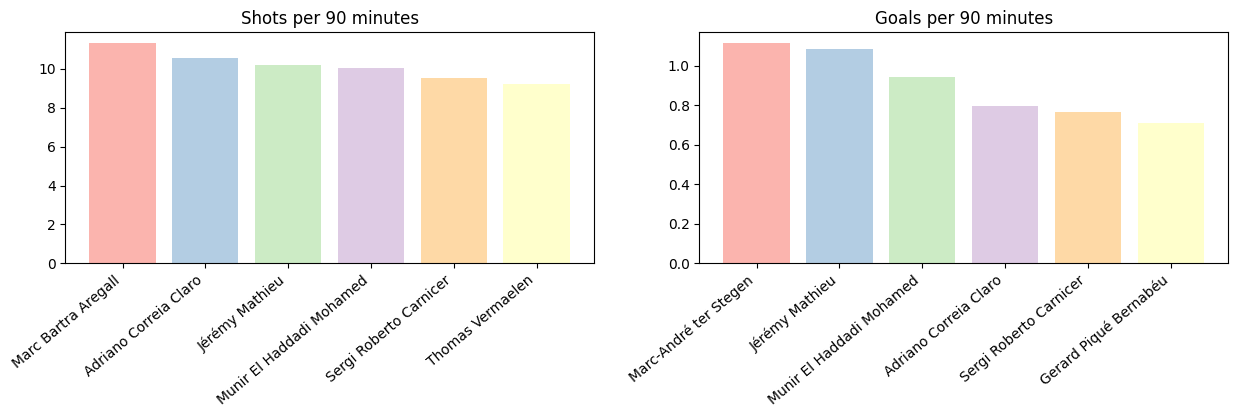

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
cmap = plt.get_cmap('Pastel1')

ax0 = grouped.sort_values('shots_per_minute', ascending=False).head(6)
axs[0].bar(ax0['player_name'], ax0['shots_per_90'], color=cmap.colors[:6])
ax1 = grouped.sort_values('goals_per_90', ascending=False).head(6)
axs[1].bar(ax1['player_name'], ax1['goals_per_90'], color=cmap.colors[:6])

axs[0].set_xticklabels(ax0.player_name, rotation=40, ha='right')
axs[1].set_xticklabels(ax1.player_name, rotation=40, ha='right')
axs[0].set_title('Shots per 90 minutes')
axs[1].set_title('Goals per 90 minutes')

plt.show()